In [1]:
import sys
import argparse
import json
import geopandas as gp
from planet import api
from operator import itemgetter, attrgetter
from requests.auth import HTTPBasicAuth
import random
import time
import numpy as np

In [2]:
import os
import requests
from shapely.geometry import Polygon
import geopandas as gp
import geopandas as gp
from shapely.geometry import mapping

#### Plot bound box on thumbnail

In [3]:
import cv2
import matplotlib.pyplot as plt
import utm
from skimage.transform import ProjectiveTransform

In [770]:
coordinates1 = [[-7.575277365620836, 41.178029181587625], 
                [-7.570342104505012, 41.40316606129548], 
                [-7.397350617984123, 41.400783984306955], 
                [-7.464770572723253, 41.17654332375692], 
                [-7.575277365620836, 41.178029181587625]]

coordinates2 = [[-7.575277365679908, 41.17802918154543], 
                 [-7.570385019805748, 41.40316606127141], 
                 [-7.460736528872651, 41.40165313270323], 
                 [-7.396449399112943, 41.17560656827673], 
                 [-7.575277365679908, 41.17802918154543]]

coordinates3 = [[-7.575277365669304, 41.17802918155932], 
                 [-7.570385019813211, 41.403166061281986], 
                 [-7.34812671908288, 41.400107971896674], 
                 [-7.398762614708891, 41.23409292716453], 
                 [-7.400827658567805, 41.22164978229023], 
                 [-7.414902941512335, 41.17586498356024], 
                 [-7.575277365669304, 41.17802918155932]]

coordinates4 = [[-7.575277365696727, 41.17806148246185], 
                 [-7.570342104532217, 41.4031660613334], 
                 [-7.402672120737121, 41.400880556847284], 
                 [-7.470134990785224, 41.1766079272446], 
                 [-7.575277365696727, 41.17806148246185]]

coordinates5 = [[-7.575277365838632, 41.17806148243563], 
                 [-7.575061967110062, 41.18827097422417], 
                 [-7.513178885488566, 41.40239350194413], 
                 [-7.271436972778285, 41.399045651648386], 
                 [-7.277316369836547, 41.17399143760598], 
                 [-7.575277365838632, 41.17806148243563]]

In [816]:
img_path1 = "3569609_2958120_2020-07-14_1013.png"
img_path2 = "3566645_2958120_2020-07-13_1062.png"
img_path3 = "3572341_2958120_2020-07-15_0f17.png"
img_path4 = "3577369_2958120_2020-07-17_0f4e.png"
img_path5 = "3582759_2958120_2020-07-19_1014.png"

In [817]:
def get_image(img_path):
    img = cv2.imread(img_path)
    plt.imshow(img)
    return img

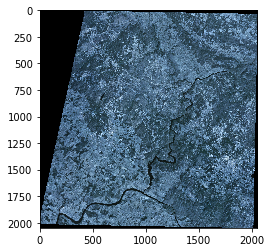

In [818]:
img = get_image(img_path5)

In [819]:
def to_utm(coordinates):
    tile_utm_coordinates = list()
    for coor in coordinates:
        x, y, z, t, = utm.from_latlon(coor[1], coor[0])
        tile_utm_coordinates.append([x, y])
    return np.array(tile_utm_coordinates)

In [820]:
tile_coordinates5 = get_vertices(coordinates5)
tile_coordinates5

array([[-7.57527737, 41.17806148],
       [-7.51317889, 41.4023935 ],
       [-7.27143697, 41.39904565],
       [-7.27731637, 41.17399144]])

In [821]:
tile_utm_coordinates = to_utm(tile_coordinates5)
tile_utm_coordinates

array([[ 619499.97401807, 4559502.2096561 ],
       [ 624282.13112975, 4584494.70433545],
       [ 644497.27820571, 4584498.10771198],
       [ 644501.61337433, 4559502.43429598]])

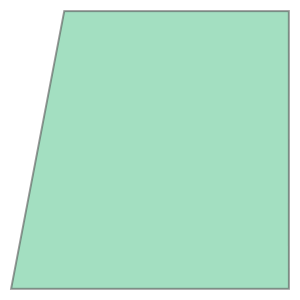

In [822]:
Polygon(tile_utm_coordinates)

In [823]:
def get_contours(img):
    image = img[:, :, 0]
    image[image > 0] = 255
    contours, hierarchy = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy 

In [824]:
contours, hierarchy = get_contours(img)

In [105]:
# отображаем контуры поверх изображения
cv2.drawContours(img, contours, -1, (255,0,0), 3, cv2.LINE_AA, hierarchy, 1 )
cv2.imshow('contours', img) # выводим итоговое изображение в окно

cv2.waitKey()
cv2.destroyAllWindows()

In [825]:
contours[0].shape

(1116, 1, 2)

In [826]:
def get_simplified_coordianates(contours):
    tile_polygon = Polygon(np.squeeze(contours[0]))
    tile_polygon = tile_polygon.simplify(3, preserve_topology=True).buffer(0)
    tile_coord = [point for point in tile_polygon.exterior.coords]
    return tile_coord

In [827]:
tile_coord = get_simplified_coordianates(contours)
tile_coord

[(420.0, 6.0),
 (6.0, 1912.0),
 (4.0, 2011.0),
 (2004.0, 2047.0),
 (2043.0, 36.0),
 (420.0, 6.0)]

In [828]:
def get_vertices(tile_coordinates):
    maxx = max(tile_coordinates, key=lambda coordinate: coordinate[0] + coordinate[1])
    maxy = max(tile_coordinates, key=lambda coordinate: coordinate[0] - coordinate[1])
    minx = min(tile_coordinates, key=lambda coordinate: coordinate[0] + coordinate[1])
    miny = min(tile_coordinates, key=lambda coordinate: coordinate[0] - coordinate[1])
    
    return np.asarray([minx, miny, maxx, maxy])

In [829]:
tile_coordinates = get_vertices(tile_coord)
tile_coordinates

array([[ 420.,    6.],
       [   4., 2011.],
       [2004., 2047.],
       [2043.,   36.]])

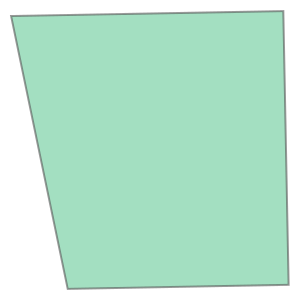

In [830]:
Polygon(tile_coordinates)

In [831]:
def plot_tile(tile_coord):
    x = [c[0] for c in tile_coord] 
    y = [c[1] for c in tile_coord]
    plt.plot(x, y)
    for i_x, i_y in zip(x, y):
        plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y))

In [832]:
tile_utm_coordinates

array([[ 619499.97401807, 4559502.2096561 ],
       [ 624282.13112975, 4584494.70433545],
       [ 644497.27820571, 4584498.10771198],
       [ 644501.61337433, 4559502.43429598]])

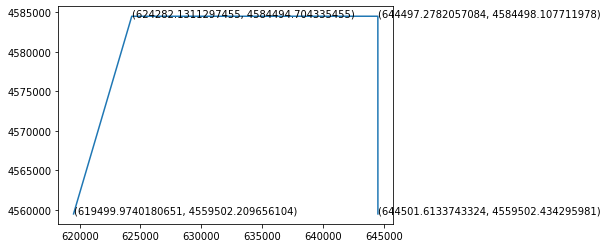

In [833]:
plot_tile(tile_utm_coordinates)

In [834]:
tile_coordinates

array([[ 420.,    6.],
       [   4., 2011.],
       [2004., 2047.],
       [2043.,   36.]])

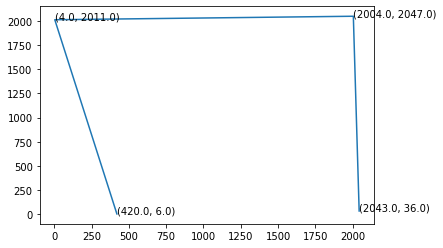

In [835]:
plot_tile(tile_coordinates)

In [836]:
#from shapely.affinity import scale
#Q1 = scale(Polygon(tile_coordinates), yfact = -1, origin = (1, 0))
#tile_coordinates = [point for point in Q1.exterior.coords]
#tile_coordinates = np.asarray(tile_coordinates)
#tile_coordinates

In [837]:
tile_coordinates

array([[ 420.,    6.],
       [   4., 2011.],
       [2004., 2047.],
       [2043.,   36.]])

In [838]:
t = np.array(
       [[  420.,    2048-6.],
       [   4., 2048-2011.],
       [ 2004., 2048-2047.],
       [2043.,   2048-36.]])

In [839]:
t

array([[4.200e+02, 2.042e+03],
       [4.000e+00, 3.700e+01],
       [2.004e+03, 1.000e+00],
       [2.043e+03, 2.012e+03]])

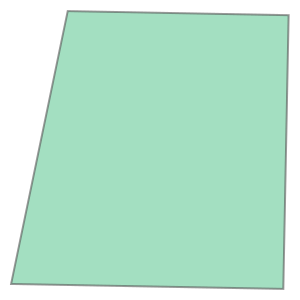

In [840]:
Polygon(t)

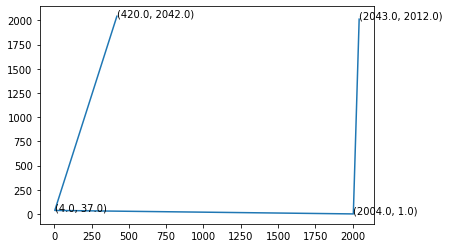

In [841]:
plot_tile(t)

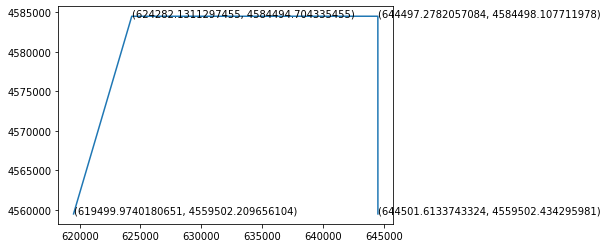

In [842]:
plot_tile(tile_utm_coordinates)

In [843]:
tile_utm_coordinates

array([[ 619499.97401807, 4559502.2096561 ],
       [ 624282.13112975, 4584494.70433545],
       [ 644497.27820571, 4584498.10771198],
       [ 644501.61337433, 4559502.43429598]])

In [844]:
t

array([[4.200e+02, 2.042e+03],
       [4.000e+00, 3.700e+01],
       [2.004e+03, 1.000e+00],
       [2.043e+03, 2.012e+03]])

In [845]:
transform_matrix = ProjectiveTransform()
transform_matrix.estimate(tile_utm_coordinates, t)
transform_matrix = transform_matrix.params
transform_matrix

array([[ 7.84258056e-02, -3.51678293e-02,  1.12270067e+05],
       [-1.39430671e-03, -9.72003793e-02,  4.46514375e+05],
       [ 2.67178715e-08, -1.66151243e-05,  7.69474202e+01]])

In [846]:
np.round(transform_matrix, 4)

array([[ 7.84000000e-02, -3.52000000e-02,  1.12270067e+05],
       [-1.40000000e-03, -9.72000000e-02,  4.46514375e+05],
       [ 0.00000000e+00, -0.00000000e+00,  7.69474000e+01]])

In [847]:
input_ = np.insert(tile_utm_coordinates, 2, 1, axis=1)
input_

array([[6.19499974e+05, 4.55950221e+06, 1.00000000e+00],
       [6.24282131e+05, 4.58449470e+06, 1.00000000e+00],
       [6.44497278e+05, 4.58449811e+06, 1.00000000e+00],
       [6.44501613e+05, 4.55950243e+06, 1.00000000e+00]])

In [848]:
r = np.dot(transform_matrix, input_.T).T[:, :2]

In [849]:
result = np.rint(r).astype(np.int32)
result

array([[ 507, 2465],
       [   3,   29],
       [1588,    1],
       [2468, 2430]], dtype=int32)

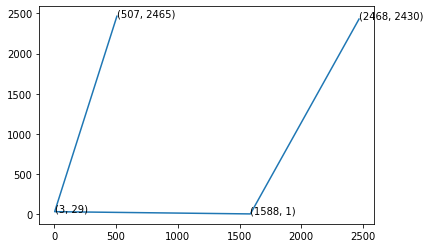

In [850]:
plot_tile(result)

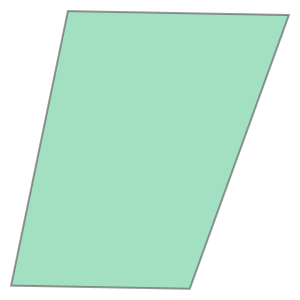

In [851]:
Polygon(result)

In [852]:
result

array([[ 507, 2465],
       [   3,   29],
       [1588,    1],
       [2468, 2430]], dtype=int32)

In [853]:
result.shape

(4, 2)

In [854]:
result[result>2048] = 2048

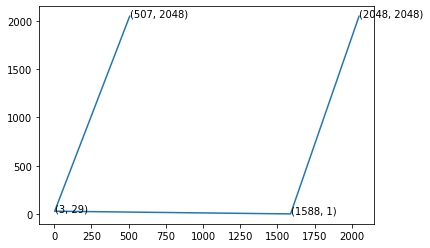

In [855]:
plot_tile(result)

In [856]:
result

array([[ 507, 2048],
       [   3,   29],
       [1588,    1],
       [2048, 2048]], dtype=int32)

In [857]:
result

array([[ 507, 2048],
       [   3,   29],
       [1588,    1],
       [2048, 2048]], dtype=int32)

In [861]:
result = np.array([[ 507, 2048-2048],
       [   3,   2048-29],
       [1588,    2048-1],
       [2048, 2048-2048]])

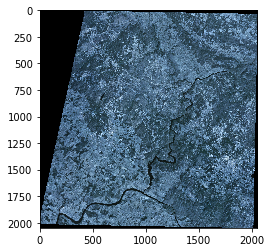

In [862]:
im = get_image(img_path5)
k=cv2.polylines(im, [result], True, (0,255,255), 3)

In [863]:
cv2.imwrite("input_real11.png", im) 

True

In [371]:
def get_agg_polygon(request_df):
    bounds = request_df.bounds
    minx, miny = bounds[["minx", "miny"]].min()
    maxx, maxy = bounds[["maxx", "maxy"]].max()
    polygon = Polygon.from_bounds(minx, miny, maxx, maxy)
    return mapping(polygon)

In [372]:
request_df = gp.read_file("bbox.geojson")
geometry = get_agg_polygon(request_df)

In [373]:
input_bbox = np.asarray(geometry['coordinates'][0])

In [374]:
input_bbox

array([[-7.49132495, 41.23572052],
       [-7.49132495, 41.26990263],
       [-7.46668866, 41.26990263],
       [-7.46668866, 41.23572052],
       [-7.49132495, 41.23572052]])

In [375]:
input_bbox_utm = to_utm(input_bbox)
input_bbox_utm

array([[ 626430.71157206, 4566022.14792188],
       [ 626364.80789087, 4569817.02762444],
       [ 628428.37837206, 4569853.16959788],
       [ 628495.35885836, 4566058.28416618],
       [ 626430.71157206, 4566022.14792188]])

In [532]:
#input real polygon
input_bbox_utm = to_utm(coordinates2)
input_bbox_utm

array([[ 619500.03275253, 4559498.62369022],
       [ 619498.77388282, 4584499.96968868],
       [ 628667.3363891 , 4584489.08447716],
       [ 634504.86327018, 4559490.71747487],
       [ 619500.03275253, 4559498.62369022]])

In [522]:
input_bbox_utm = np.insert(input_bbox_utm, 2, 1, axis=1)
input_bbox_utm

array([[6.19500033e+05, 4.55949862e+06, 1.00000000e+00],
       [6.19498774e+05, 4.58449997e+06, 1.00000000e+00],
       [6.28667336e+05, 4.58448908e+06, 1.00000000e+00],
       [6.34504863e+05, 4.55949072e+06, 1.00000000e+00],
       [6.19500033e+05, 4.55949862e+06, 1.00000000e+00]])

In [523]:
result = np.dot(transform_matrix, input_bbox_utm.T)
result.T

array([[5.23700950e+01, 2.91038305e-11, 1.45472486e+00],
       [2.18370943e+00, 1.09785992e+03, 5.45927359e-01],
       [6.56865326e+02, 1.10914220e+03, 5.45569207e-01],
       [1.12377084e+03, 1.88991214e+01, 1.45377857e+00],
       [5.23700950e+01, 2.91038305e-11, 1.45472486e+00]])

In [524]:
result = np.dot(transform_matrix, input_bbox_utm.T).T[:, :2]

In [237]:
img.shape

(2048, 2048, 3)

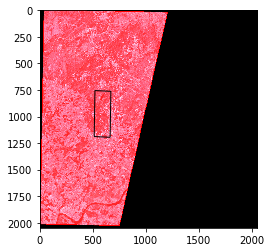

In [167]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Polygon(result, fill=False)

# Add the patch to the Axes
ax.add_patch(rect)

#plt.show()

In [166]:
fig.savefig('img1.png')
plt.close(fig)

In [154]:
from PIL import Image, ImageDraw
im = Image.open(img_path1)
d = ImageDraw.Draw(im)

top = (534, 295)
left = (522, 462)
b = (669, 466)
b1 = (682, 300)
#b2=(682, 300)

line_color = (0, 0, 255)

d.line([(521, 755), (514, 1188), (664, 1195), (671, 762)], fill=line_color, width=2)

im.save("drawn_grid.png")

In [392]:
print(im)

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=2048x2048 at 0x7FD875EAA220>


AttributeError: 'AxesImage' object has no property 'color'

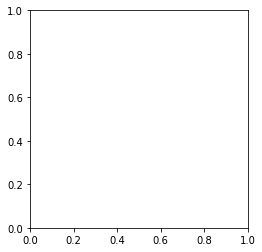

In [382]:
import matplotlib.patches as patches

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a Rectangle patch
#rect = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='b',facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)
plt.plot(r, color='green')
plt.show()

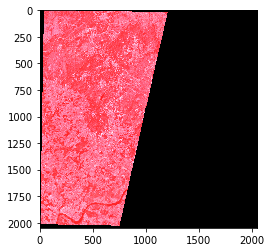

In [371]:
plt.imshow(img)

#### Work with features

In [145]:
request_data = gp.read_file("Portugal_features.geojson")

In [146]:
rd = gp.read_file("bbox.geojson")

In [147]:
request_data.head()

,AdMapKey,LAYER,NOME,ID,Area,geometry
0,3,MT,None,23C,2041,"POLYGON ((-7.48014 41.24676, -7.48103 41.24681..."
1,6,FP,SALGUEIRNHO,29A,25204,"POLYGON ((-7.48083 41.24523, -7.48077 41.24539..."
2,7,Samrr,SALGUEIRNHO,29B,12113,"POLYGON ((-7.48100 41.24469, -7.48098 41.24474..."
3,8,MoGal,SALGUEIRNHO,29C,29140,"POLYGON ((-7.47858 41.24460, -7.47859 41.24459..."
4,9,INC,None,None,13316,"POLYGON ((-7.47293 41.24265, -7.47289 41.24272..."


In [148]:
request_data.crs

{'init': 'epsg:4326'}

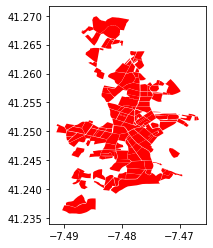

In [149]:
ax = request_data.plot(color='red')

In [163]:
def get_agg_polygon(request_df):
    bounds = request_data.bounds
    minx, miny = bounds[["minx", "miny"]].min()
    maxx, maxy = bounds[["maxx", "maxy"]].max()
    return Polygon.from_bounds(minx, miny, maxx, maxy)

In [164]:
polygon = get_agg_polygon(request_data)

In [171]:
print(polygon)

POLYGON ((-7.491324951139547 41.23572051821126, -7.491324951139547 41.26990262768597, -7.466688660500251 41.26990262768597, -7.466688660500251 41.23572051821126, -7.491324951139547 41.23572051821126))


In [183]:
from shapely.geometry import mapping

In [184]:
mapping(polygon)

{'type': 'Polygon',
 'coordinates': (((-7.491324951139547, 41.23572051821126),
   (-7.491324951139547, 41.269902627685966),
   (-7.466688660500251, 41.269902627685966),
   (-7.466688660500251, 41.23572051821126),
   (-7.491324951139547, 41.23572051821126)),)}

In [185]:
mapping?

Signature: mapping(ob)
Docstring: Returns a GeoJSON-like mapping
File:      ~/ProgramFiles/anaconda3/envs/planet_tiles/lib/python3.8/site-packages/shapely/geometry/geo.py
Type:      function


In [181]:
geopandas.GeoSeries([polygon]).geo_interface()

AttributeError: 'GeoSeries' object has no attribute 'geo_interface'

In [173]:
polygon.to_json()

AttributeError: 'Polygon' object has no attribute 'to_json'

In [166]:
polygon.area

0.0008421203836830883

In [168]:
request_data.area.sum()

0.0002475549819542924

In [150]:
from shapely.ops import unary_union

In [24]:
polygons = request_data.geometry.values

In [51]:
for index, p in enumerate(polygons):
    if not p.is_valid:
        print(f"Index: {index}")

Index: 24
Index: 31
Index: 75


In [65]:
polygons[75] = polygons[75].buffer(0)
polygons[24] = polygons[24].buffer(0)
polygons[31] = polygons[31].buffer(0)

In [66]:
united = unary_union(polygons)

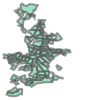

In [67]:
united

In [84]:
str(type(polygons[0]))

shapely.geometry.polygon.Polygon

In [89]:
polygons

In [88]:
for index, p in enumerate(polygons):
    if str(type(p)) == 'shapely.geometry.multipolygon.MultiPolygon':
        print(index)

In [90]:
eps = 0.01

omega = cascaded_union([
    Polygon(component.exterior).buffer(eps).buffer(-eps) for component in polygons[:15]
])

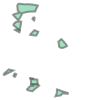

In [91]:
omega

In [77]:
from shapely.ops import cascaded_union

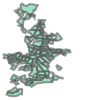

In [78]:
cascaded_union(polygons)

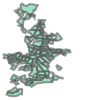

In [72]:
united

In [141]:
request_data.bounds

,minx,miny,maxx,maxy
0,-7.481135,41.246755,-7.480138,41.247098
1,-7.480998,41.245155,-7.478809,41.246723
2,-7.481002,41.244597,-7.478439,41.245231
3,-7.482114,41.243047,-7.478575,41.244689
4,-7.472945,41.242229,-7.469534,41.243651
...,...,...,...,...
166,-7.483722,41.265968,-7.480299,41.268377
167,-7.486593,41.248749,-7.485317,41.249387
168,-7.467131,41.251916,-7.466689,41.252589
169,-7.468485,41.252588,-7.467279,41.253043


In [92]:
united.bounds

(-7.491324951139547, 41.23572051821126, -7.466688660500251, 41.269902627685966)

In [112]:
pp = Polygon.from_bounds(*united.bounds)

In [144]:
request_data.crs

{'init': 'epsg:4326'}

In [142]:
pp.area

0.0008421203836830883

In [120]:
type(united)

shapely.geometry.multipolygon.MultiPolygon

In [122]:
import pandas as pd

In [126]:
df = pd.DataFrame(
    {'Country': 'Portugal',
     'geometry': [united]})

In [127]:
df

,Country,geometry
0,Portugal,(POLYGON ((-7.478099216694696 41.2542925649837...


In [128]:
gdf = geopandas.GeoDataFrame(df)

In [131]:
pf = pd.DataFrame(
    {'poly': 'P',
     'geometry': [pp]})
pdf = geopandas.GeoDataFrame(pf)

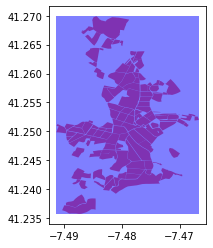

In [132]:
ax = gdf.plot(color='red', alpha=0.6)
ax = pdf.plot(ax=ax, color='blue', markersize=2, alpha=0.5)

In [118]:
gp.GeoDataFrame?

Init signature: gp.GeoDataFrame(*args, **kwargs)
Docstring:     
A GeoDataFrame object is a pandas.DataFrame that has a column
with geometry. In addition to the standard DataFrame constructor arguments,
GeoDataFrame also accepts the following keyword arguments:

Parameters
----------
crs : str (optional)
    Coordinate system
geometry : str or array (optional)
    If str, column to use as geometry. If array, will be set as 'geometry'
    column on GeoDataFrame.
File:           ~/ProgramFiles/anaconda3/envs/planet_tiles/lib/python3.8/site-packages/geopandas/geodataframe.py
Type:           type
Subclasses:     


In [97]:
p = polygons[0]

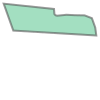

In [98]:
p

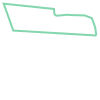

In [99]:
p.exterior

In [107]:
p.x

AttributeError: 'Polygon' object has no attribute 'x'

In [105]:
p.bounds

(-7.481134512845569, 41.246755397537584, -7.480137920253195, 41.24709764066048)

In [100]:
x, y = p.exterior.coords.xy

In [106]:
for i in y:
    print(i)

41.246755397537584
41.24680847573329
41.24709764066048
41.24704080968635
41.24698651365181
41.24698268455419
41.246978253201206
41.2469715025921
41.24696854775255
41.24697426443945
41.246978526547544
41.246973933022204
41.24697194869164
41.24694179259377
41.24684153425949
41.246755397537584


In [102]:
y

array('d', [41.246755397537584, 41.24680847573329, 41.24709764066048, 41.24704080968635, 41.24698651365181, 41.24698268455419, 41.246978253201206, 41.2469715025921, 41.24696854775255, 41.24697426443945, 41.246978526547544, 41.246973933022204, 41.24697194869164, 41.24694179259377, 41.24684153425949, 41.246755397537584])

In [96]:
p = Polygon([(-7.491324951139547, 41.23572051821126), (-7.466688660500251, 41.269902627685966)])

ValueError: A LinearRing must have at least 3 coordinate tuples

In [76]:
filled_shape = Polygon(united.exterior)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

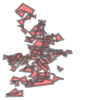

In [75]:
united.simplify(tolerance=0.5)

In [ ]:
cities_with_country = geopandas.sjoin(cities, countries, how="inner", op='intersects')

In [ ]:
request_data

In [13]:
rd = gp.read_file("bbox.geojson")

In [14]:
rd

,geometry
0,"POLYGON ((-7.46669 41.23572, -7.46669 41.26990..."


In [2]:
def createParser():
    parser = argparse.ArgumentParser()
    parser.add_argument ('file', nargs='?')
    return parser

In [395]:
def _result_to_list(result_list):
    #for item in result_list.items_iter(100):
     #   print(item)
    
    items = [
    {'id': item['id'], 
    'visible_percent': item['properties']['visible_percent'], 
    'cloud_percent': item['properties']['cloud_percent'], 
    'thumbnail': item['_links']['thumbnail'],
    'geometry': item['geometry'],}
        
    for item in result_list.items_iter(100) if 'visible_percent' in item['properties']]    
    
    return items 

In [396]:
def _get_best_items(items, cloud_percent=30):
    # Sort by best visible_percent2
    
    #result_list = sorted(items, key=itemgetter(1), reverse=True)
    result_list = sorted(items, key=lambda item: item['visible_percent'], reverse=True)
    
    # Get list with only best visible_percent
    #result_list = list(filter(lambda item: item[1] >= result_list[0][1], result_list))
    result_list = list(filter(lambda item: item['visible_percent'] >= result_list[0]['visible_percent'], result_list))
    
    #print(result_list)
    
    # Get list with only best visible_percent and setted cloud_percent
    #result_list = list(filter(lambda item: item[2] <= cloud_percent, result_list))
    #result_list = sorted(result_list, key=itemgetter(2))
    
    result_list = list(filter(lambda item: item['cloud_percent'] <= cloud_percent, result_list))
    result_list = sorted(result_list, key=lambda item: item['cloud_percent'])
    
    #print("Cloud percent")
    #print(len(result_list))
    #print(result_list)
    
    return result_list

In [397]:
def _overlap(target, result_list, min_percent=0.01):
    
    target_polygon = Polygon(target['filter_like']['config'][0]['config']['coordinates'][0])
    
    for index, item in enumerate(result_list):
        item_polygon = Polygon(item['geometry']['coordinates'][0])
        percent = round((target_polygon.intersection(item_polygon).area / target_polygon.area) * 100, 1)
        if percent < min_percent:
            print(f"Item {item['id']} has small intersection percent {percent}")
        item['overlap_percent'] = percent
        result_list[index] = item
    return result_list.copy()

In [398]:
def load_thumbnail(thb_url, api_key, width, password = ''):
    params = {'width': width}
    response = requests.get(thb_url, auth=HTTPBasicAuth(api_key, password), params=params)
    if response.status_code == 200:
        return response.content
    else:
        raise requests.HTTPError(f"Cannot load thumbnail for {thb_url}, status code: {response.status_code}, {response.text}")

In [399]:
def save_thumbnail(tile_id, content, path="thumbnails/"):
    # check permissions
    os.makedirs(path, exist_ok=True)
    with open(f"{path}{tile_id}.png", "wb") as file:
        file.write(content)

In [400]:
def store_thumbnails(best_quality_items, api_key, width=512, tries=2):
    
    max_width = 512
    min_width = 256
    
    if width < min_width:
        print(f"Value {width=}, setting width to min {min_width}")
        width = 256
    if width > max_width:
        print(f"Value {width=}, setting width to max {max_width}")
        width = max_width
        
    # add list as needed
    for item in best_quality_items: 
        thb_url = item['thumbnail']
        for try_ in range(tries):
            try:
                content = load_thumbnail(thb_url, api_key, width)
                save_thumbnail(item['id'], content)
                break
            except Exception as err:
                pause = random.uniform(0.5, 1.9)  
                print(f"Cannot get content for {item['id']}, {str(err)}, next try in {pause} sec")
                time.sleep(pause)

In [401]:
# raise cloud cover threshold on cloudiness and return a list of found images

In [402]:
path = r"home/quantum/WorkQuantum/Task02_PlanetTiles/planet_script_env/data.json"
api_key = "6d3f2f556e49414f8f8791d8d722bb24"

path = "data.json"


In [403]:
#quantum
api_key = "15b12471bb40493487a6e041d22d7ec0"

In [404]:
with open(path) as data:
        request_data = json.load(data)

In [405]:
client = api.ClientV1(api_key)

In [406]:
def _print_item(item):
    print(f"ID: {item['id']}, overlap percent: {item['overlap_percent']}, visible percent {item['visible_percent']}, cloud percent {item['cloud_percent']}")

In [407]:
     for data in request_data:
        request = api.filters.build_search_request(**data)
        #print(request)
        
        results = client.quick_search(request)        
        res = results
        result_list = _result_to_list(results)
        
        if not result_list:
            print('Items not found.')
        else: 
            print(f"Found {len(result_list)} items")
            
            result_list = _overlap(data, result_list)
            
            best_quality_items = _get_best_items(result_list)
            
            if best_quality_items:
                print("Loading and saving thumbnails of best items")
                store_thumbnails(best_quality_items, api_key)
            
                print("\nBEST QUALITY ITEMS:\n")
                for item in best_quality_items:
                    _print_item(item)
                print("\n")
            else:
                print("No items found satisfying the condition")

Found 6 items
Loading and saving thumbnails of best items

BEST QUALITY ITEMS:

ID: 3045023_3762108_2020-01-18_1069, overlap percent: 97.9, visible percent 87, cloud percent 10
ID: 3045023_3762107_2020-01-18_1069, overlap percent: 6.7, visible percent 87, cloud percent 10


Found 5 items
Loading and saving thumbnails of best items

BEST QUALITY ITEMS:

ID: 3009453_3762108_2020-01-07_1025, overlap percent: 23.8, visible percent 96, cloud percent 4
ID: 3009453_3762107_2020-01-07_1025, overlap percent: 6.7, visible percent 96, cloud percent 4




In [256]:
3045023_3762108_2020-01-18_1069
3009453_3762108_2020-01-07_1025

In [338]:
r = overlap(data, res)

AttributeError: 'list' object has no attribute 'deepcopy'